In [23]:
import os
import numpy as np
import argparse
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from utils import preprocess_data, SequenceDataset, train_model, score_model, log, get_predictions, plot_predictions
from model import LSTMRegression

In [24]:
forecast_lead=0
batch_size=32
sequence_length=30
learning_rate = 5e-5
num_hidden_units=16
num_layers=1
dropout=0
num_epochs=2

In [37]:
df = pd.read_parquet("../data/mta_subway_221231_100wk_dbscan.parquet")
df = df.drop(
    [
        "THIRTY ST_ent", 
        "THIRTY ST_ex", 
        
        ],
    axis=1)

df.shape

(16800, 704)

<AxesSubplot: xlabel='TIME'>

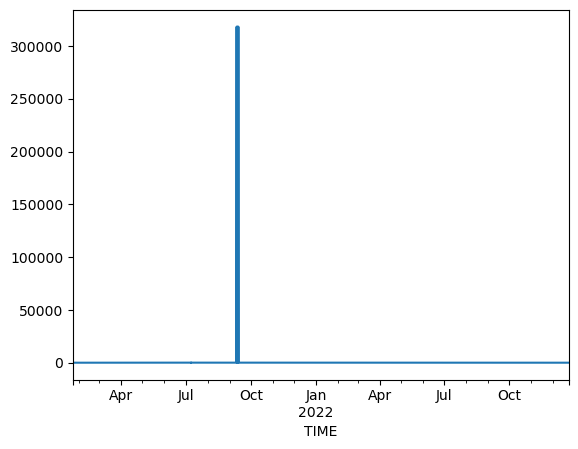

In [38]:
df['121 ST_ent'].plot()

In [46]:
df['121 ST_ent'][df['121 ST_ent']>150] = np.nan
df['121 ST_ex'][df['121 ST_ex']>150] = np.nan

<AxesSubplot: xlabel='TIME'>

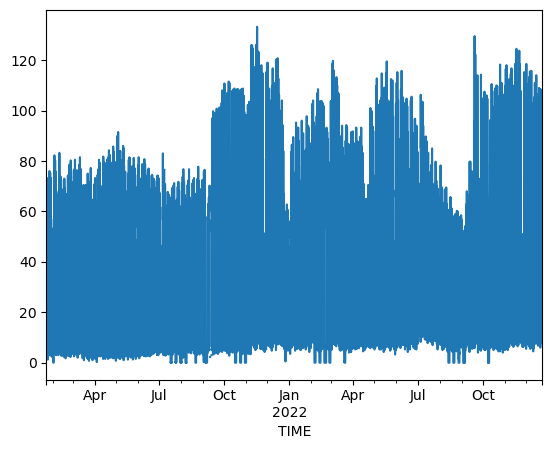

In [47]:
df['121 ST_ent'].plot()

<AxesSubplot: xlabel='TIME'>

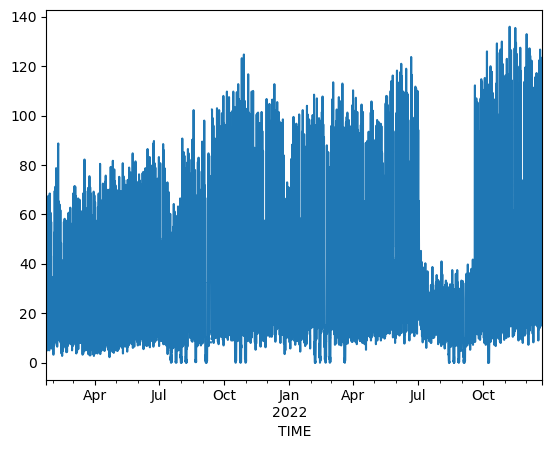

In [48]:
df['121 ST_ex'].plot()

In [50]:
df['121 ST_ent'] = df['121 ST_ent'].bfill().ffill()
df['121 ST_ex'] = df['121 ST_ex'].bfill().ffill()

In [51]:
df.to_parquet('../data/mta_subway_221231_100wk_dbscan.parquet')

In [53]:
pd.read_parquet('../data/mta_subway_221231_100wk_dbscan.parquet')

,1 AV_ent,1 AV_ex,103 ST-CORONA_ent,103 ST-CORONA_ex,103 ST_ent,103 ST_ex,104 ST_ent,104 ST_ex,110 ST_ent,110 ST_ex,...,WOODLAWN_ent,WOODLAWN_ex,WORLD TRADE CTR_ent,WORLD TRADE CTR_ex,WTC-CORTLANDT_ent,WTC-CORTLANDT_ex,YORK ST_ent,YORK ST_ex,ZEREGA AV_ent,ZEREGA AV_ex
TIME,,,,,,,,,,,,,,,,,,,,,
2021-01-23 00:00:00,12.00,63.50,233.25,37.50,12.00,31.50,31.50,3.25,31.25,27.75,...,40.0,12.25,1.75,2.5,1.00,5.75,0.00,0.0,0.25,6.0
2021-01-23 01:00:00,12.00,63.50,233.25,37.50,12.00,31.50,31.50,3.25,31.25,27.75,...,40.0,12.25,1.75,2.5,1.00,5.75,0.00,0.0,0.25,6.0
2021-01-23 02:00:00,12.00,63.50,233.25,37.50,12.00,31.50,31.50,3.25,31.25,27.75,...,40.0,12.25,1.75,2.5,1.00,5.75,0.00,0.0,0.25,6.0
2021-01-23 03:00:00,12.00,63.50,233.25,37.50,12.00,31.50,31.50,3.25,31.25,27.75,...,40.0,12.25,1.75,2.5,1.00,5.75,0.00,0.0,0.25,6.0
2021-01-23 04:00:00,12.00,63.50,233.25,37.50,12.00,31.50,31.50,3.25,31.25,27.75,...,40.0,12.25,1.75,2.5,1.00,5.75,0.00,0.0,0.25,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 19:00:00,520.50,974.75,559.25,1689.75,603.75,952.75,74.50,151.50,267.50,518.25,...,120.0,85.00,467.00,501.5,357.75,360.25,221.25,184.5,37.25,122.5
2022-12-23 20:00:00,205.75,498.25,164.75,887.00,603.75,952.75,20.75,78.25,83.00,246.00,...,50.5,49.50,110.00,232.5,357.75,360.25,221.25,184.5,37.25,122.5
2022-12-23 21:00:00,205.75,498.25,164.75,887.00,603.75,952.75,20.75,78.25,83.00,246.00,...,50.5,49.50,110.00,232.5,357.75,360.25,221.25,184.5,37.25,122.5


In [26]:
df1 = df.max().sort_values(ascending=False).copy()

In [27]:
df1[(df1>1e+06)]

Series([], dtype: float64)

In [28]:
df1[(df1<1e+06)&(df1>1e05)]

121 ST_ent       318341.500000
121 ST_ex        222647.500000
THIRTY ST_ent    123632.184147
dtype: float64

In [ ]:
df['12

<AxesSubplot: xlabel='TIME'>

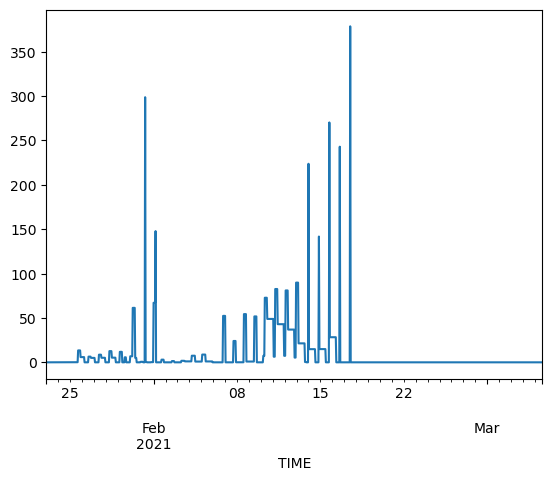

In [36]:
df['THIRTY ST_ent'].head(1000).plot()

In [ ]:
df['THIRTY ST_ex'].plot()

In [ ]:
df['77 ST_ent'].plot()

In [ ]:
len(df)

In [ ]:
df['77 ST_ent'].iloc[11930:12100].plot()

In [ ]:
df['77 ST_ent'].iloc[12000:12100].plot()

In [13]:
from sklearn.cluster import DBSCAN

<AxesSubplot: xlabel='TIME'>

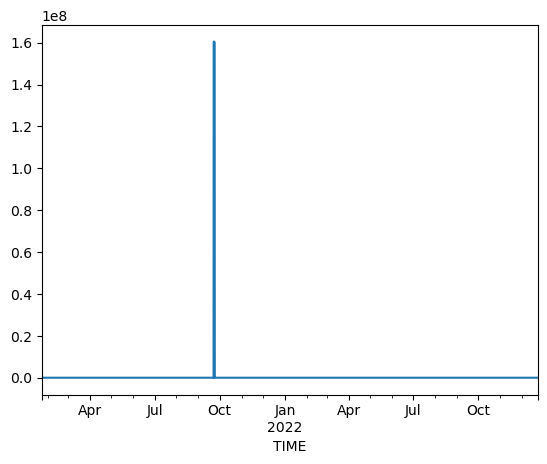

In [22]:
col = 'ASTORIA BLVD_ex'
df[col].plot()

In [9]:
eps = int(df[col].quantile(0.99)*1.5)
eps

9135

In [10]:
min_samples = int(len(df)/1000)
min_samples

16

In [11]:
eps = 1000

<AxesSubplot: xlabel='TIME'>

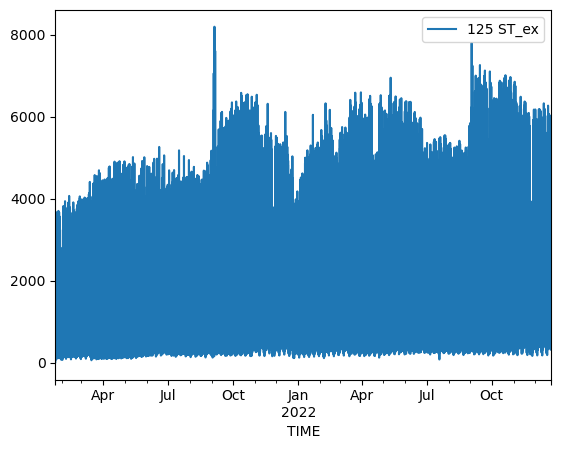

In [14]:
df1 = df[[col]].copy()
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(df1)
outliers = np.argwhere(dbscan.labels_ == -1).flatten()
df1.iloc[outliers,:] = np.nan
df1 = df1.fillna(method='bfill').fillna(method='ffill')
df1.plot()

In [ ]:
df1.head(2000).plot()

In [ ]:
df['14 ST_ent'].plot()

In [ ]:
df_train, df_test, features = preprocess_data(
        df,
        #target_feature, 
        forecast_lead=forecast_lead,
        train_test_split=0.8
        )

In [ ]:
df_test.max().sort_values(ascending=False)

In [ ]:
df_test['JFK JAMAICA CT1_ent'].plot()

In [ ]:
df_test['ATL AV-BARCLAY_ex'].plot()

In [ ]:
df['ATL AV-BARCLAY_ex']

In [ ]:
df['ATL AV-BARCLAY_ex'].max()